<a href="https://colab.research.google.com/github/arman-sakif/Mitigating-Racial-Bias-in-NLU-with-GNN/blob/main/data_cleaning_for_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.INFO) # disable INFO and DEBUG logging everywhere

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import kagglehub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("danofer/compass")
print("Path to dataset files:", path)

100%|██████████| 2.72M/2.72M [00:00<00:00, 43.3MB/s]


Path to dataset files: /root/.cache/kagglehub/datasets/danofer/compass/versions/1


In [ ]:
df = pd.read_csv(path + "/compas-scores-raw.csv")

In [ ]:
pd.set_option('display.max_columns', None)
print(df.shape)
df.head(5)

(60843, 28)


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [ ]:
df.shape

(60843, 28)

In [ ]:
df['AssessmentType'].value_counts()

,count
AssessmentType,
New,56139
Copy,4704


In [ ]:
# dropping copy datas as they are less significant
df = df[df["AssessmentType"] == 'New']
df.shape

(56139, 28)

In [ ]:
df['DisplayText'].value_counts()

,count
DisplayText,
Risk of Violence,18713
Risk of Recidivism,18713
Risk of Failure to Appear,18713


In [ ]:
# Only taking one category
df = df[df["DisplayText"] == 'Risk of Recidivism']

In [ ]:
df.shape

(18713, 28)

In [ ]:
df['Scale_ID'].value_counts()

,count
Scale_ID,
8,18713


In [ ]:
df['ScaleSet'].value_counts()

,count
ScaleSet,
Risk and Prescreen,18138
All Scales,575


In [ ]:
# Only taking one category
df = df[df["ScaleSet"] == 'Risk and Prescreen']

In [ ]:
df['AssessmentReason'].value_counts()

,count
AssessmentReason,
Intake,18138


In [ ]:
columns_to_drop = ['AssessmentID', 'IsCompleted', 'IsDeleted', 'AssessmentID', 'Case_ID', 'MiddleName', 'AssessmentType', 'Scale_ID', 'AssessmentReason', 'ScaleSet']


In [ ]:
df = df.drop(columns=columns_to_drop)

In [ ]:
df.shape

(18138, 19)

## Done later

In [ ]:
df['ScoreText'].unique()

array(['Low', 'High', 'Medium', nan], dtype=object)

In [ ]:
df.dropna(subset=['ScoreText'], axis=0, inplace=True)
df.shape

(18104, 19)

In [ ]:
#for the sake of simplicity, considering all the medium as high
df['ScoreText'] = df['ScoreText'].replace('Medium', 'High')
df['ScoreText'].value_counts()

,count
ScoreText,
Low,10903
High,7201


In [ ]:
df['Language'].value_counts()

,count
Language,
English,18023
Spanish,81


In [ ]:
df['Ethnic_Code_Text'].value_counts()

,count
Ethnic_Code_Text,
African-American,7716
Caucasian,6635
Hispanic,2724
Other,810
Asian,103
Native American,65
Arabic,23
African-Am,15
Oriental,13


In [ ]:
df['Ethnic_Code_Text'] = df['Ethnic_Code_Text'].replace('African-Am', 'African-American')

In [ ]:
df['Ethnic_Code_Text'].unique()

array(['Caucasian', 'African-American', 'Hispanic', 'Other', 'Asian',
       'Native American', 'Oriental', 'Arabic'], dtype=object)

In [ ]:
# Merge specified categories into 'Other'
merge_dict = {
    'Hispanic': 'Other',
    'Other': 'Other',
    'Asian': 'Other',
    'Native American': 'Other',
    'Oriental': 'Other',
    'Arabic': 'Other'
}

df['Ethnic_Code_Text'] = df['Ethnic_Code_Text'].replace(merge_dict)
df['Ethnic_Code_Text'].value_counts()

,count
Ethnic_Code_Text,
African-American,7731
Caucasian,6635
Other,3738


In [ ]:
columns_to_drop = ['DisplayText', 'RecSupervisionLevelText', 'RawScore', 'DecileScore']

In [ ]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
len(df.columns)

15

In [ ]:
df1 = df[df["Language"] == 'English']
df1.shape

(18023, 15)

In [ ]:
df1 = df[df["Ethnic_Code_Text"] != 'Other']
df1.shape

(14366, 15)

In [ ]:
df1["Ethnic_Code_Text"].value_counts()

,count
Ethnic_Code_Text,
African-American,7731
Caucasian,6635


In [ ]:
# Sample 6635 rows from 'African-American' category
african_american_sample = df1[df1['Ethnic_Code_Text'] == 'African-American'].sample(n=6635, random_state=42)

# Get all rows of 'Caucasian' (since it has 6635 rows, we can keep all of them)
caucasian_rows = df1[df1['Ethnic_Code_Text'] == 'Caucasian']

# Combine the sampled 'African-American' rows with the 'Caucasian' rows
balanced_df = pd.concat([african_american_sample, caucasian_rows])

print(balanced_df.shape)
print(balanced_df['Ethnic_Code_Text'].value_counts())

(13270, 15)
Ethnic_Code_Text
African-American    6635
Caucasian           6635
Name: count, dtype: int64


In [ ]:
balanced_df.columns

Index(['Person_ID', 'Agency_Text', 'LastName', 'FirstName', 'Sex_Code_Text',
       'Ethnic_Code_Text', 'DateOfBirth', 'ScaleSet_ID', 'Language',
       'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'Screening_Date',
       'RecSupervisionLevel', 'ScoreText'],
      dtype='object')

In [ ]:
balanced_df.shape

(13270, 15)

In [ ]:
balanced_df['ScoreText'].value_counts()

,count
ScoreText,
Low,7584
High,5686


In [ ]:
# Sample 5686 rows from 'Low' category
low_sample = balanced_df[balanced_df['ScoreText'] == 'Low'].sample(n=5686, random_state=42)

# Get all rows of 'High' (since it has 5686 rows, we can keep all of them)
high_rows = balanced_df[balanced_df['ScoreText'] == 'High']

# Combine the sampled 'African-American' rows with the 'Caucasian' rows
balanced_df = pd.concat([low_sample, high_rows])

# Shuffle the combined dataframe to mix the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df.shape)
print(balanced_df['ScoreText'].value_counts())

(11372, 15)
ScoreText
Low     5686
High    5686
Name: count, dtype: int64


In [ ]:
df = balanced_df.copy()

In [ ]:
balanced_df.head(2)

,Person_ID,Agency_Text,LastName,FirstName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,ScoreText
0,51449,Probation,walters,lucas,Male,Caucasian,07/20/79,22,English,Post Sentence,Probation,Married,1/22/13 0:00,1,Low
1,10419,PRETRIAL,THOMPSON,LEONARDO,Male,African-American,01/23/74,22,English,Pretrial,Jail Inmate,Single,10/11/13 0:00,3,High


## Convert Categorical to numerical

In [ ]:
categorical_columns = list(df.select_dtypes(include='object').columns)
print(categorical_columns)

['Agency_Text', 'LastName', 'FirstName', 'Sex_Code_Text', 'Ethnic_Code_Text', 'DateOfBirth', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'Screening_Date', 'ScoreText']


In [ ]:
# Initialize Label Encoder
label_encoders = {}

# Apply Label Encoding to each categorical column
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Convert to string to handle mixed types
        label_encoders[col] = le  # Store the encoder if needed later for inverse transform

# Display the transformed DataFrame
print(df)

       Person_ID  Agency_Text  LastName  FirstName  Sex_Code_Text  \
0          51449            3      6986       4434              1   
1          10419            2      5418       2228              1   
2          15292            3      6359       4142              1   
3          66783            2      1636       1514              1   
4          65000            2      5949       3098              1   
...          ...          ...       ...        ...            ...   
11367      56744            2      3879        402              1   
11368      38601            2      5886        645              0   
11369      51360            2       903       2535              0   
11370      57821            2      5543       3410              0   
11371      55902            3      2097       2512              1   

       Ethnic_Code_Text  DateOfBirth  ScaleSet_ID  Language  LegalStatus  \
0                     1         4011           22         0            4   
1                  

In [ ]:
df.head(2)

,Person_ID,Agency_Text,LastName,FirstName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,ScoreText
0,51449,3,6986,4434,1,1,4011,22,0,4,4,1,28,1,1
1,10419,2,5418,2228,1,0,468,22,0,5,0,4,66,3,0


In [ ]:
# currently low is 1
# It makes more sense to assign 1 to High and 0 to low
# Swap 0s with 1s and 1s with 0s
df['ScoreText'] = 1 - df['ScoreText']
df["ScoreText"].value_counts()

,count
ScoreText,
0,5686
1,5686


## Correlation Matrix

In [ ]:
# Generate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation of all attributes with 'ScoreText'
scoretext_correlation = correlation_matrix['ScoreText'].sort_values(ascending=False)
print("Correlation with 'ScoreText':\n")
print(scoretext_correlation)

Correlation with 'ScoreText':

ScoreText              1.000000e+00
RecSupervisionLevel    7.165100e-01
MaritalStatus          2.433072e-01
LegalStatus            6.784212e-02
LastName               2.076716e-02
DateOfBirth            1.806106e-02
FirstName              2.038106e-03
Sex_Code_Text          4.190738e-17
Screening_Date        -1.568721e-02
CustodyStatus         -6.381985e-02
Agency_Text           -8.623092e-02
Person_ID             -1.880803e-01
Ethnic_Code_Text      -2.451630e-01
ScaleSet_ID                     NaN
Language                        NaN
Name: ScoreText, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

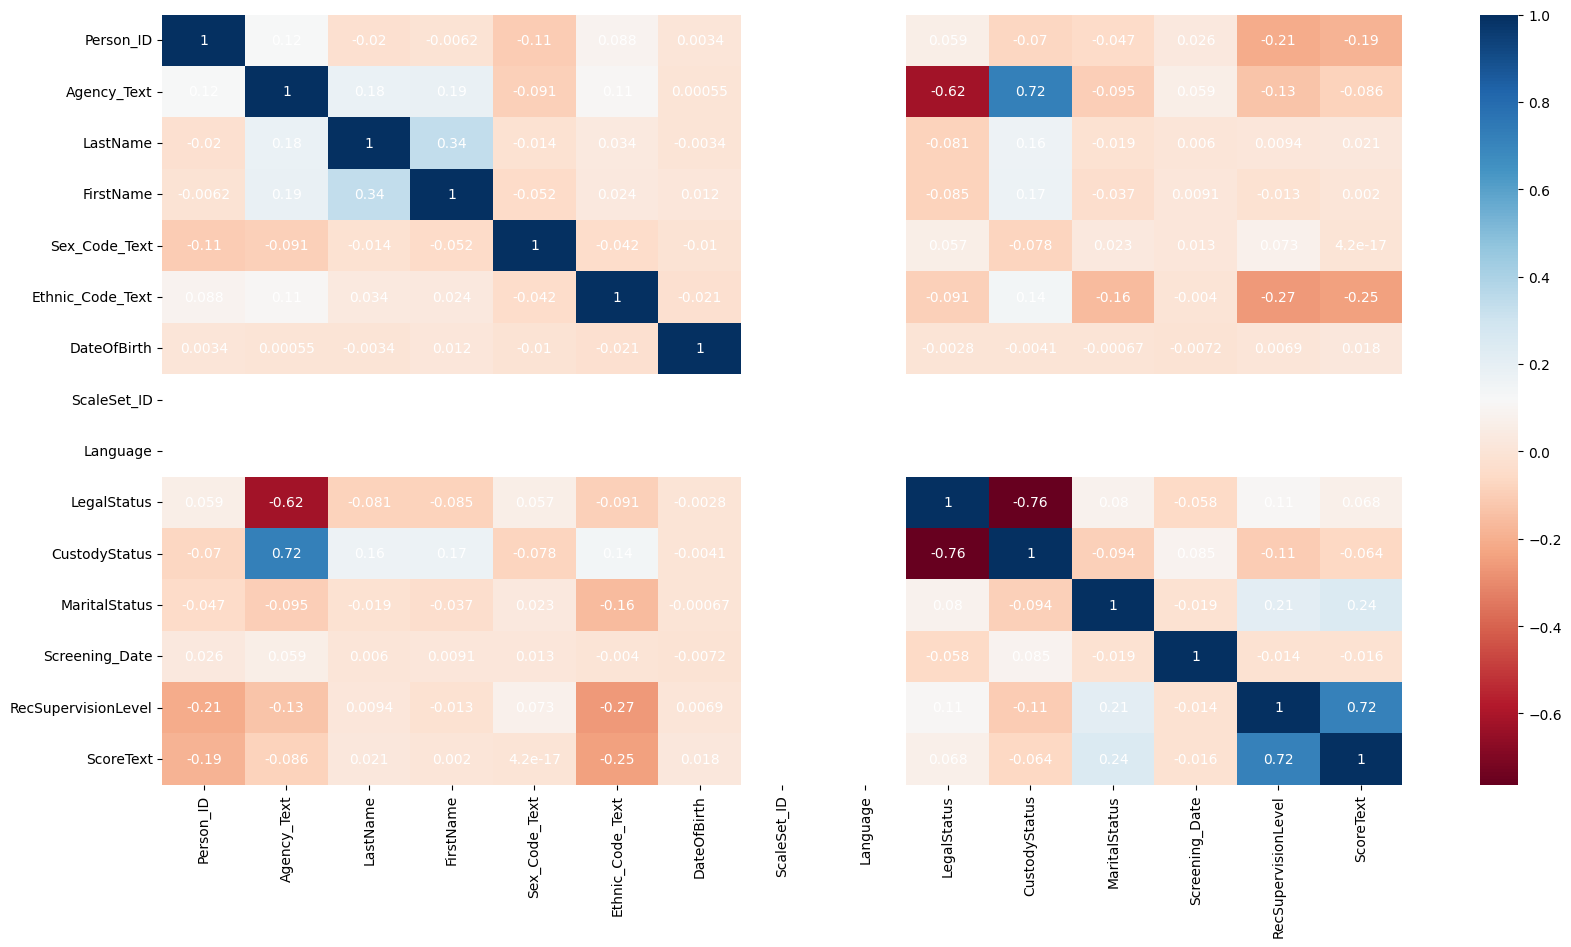

In [ ]:
df2 = df.copy()
corr = df2.corr()

plt.figure(figsize=(20,10)) # this sets the size of the figure to width=10 inches, height=8 inches
sns.heatmap(corr, annot=True, cmap='RdBu', annot_kws={"size": 10, "color": "white"})
plt.show()

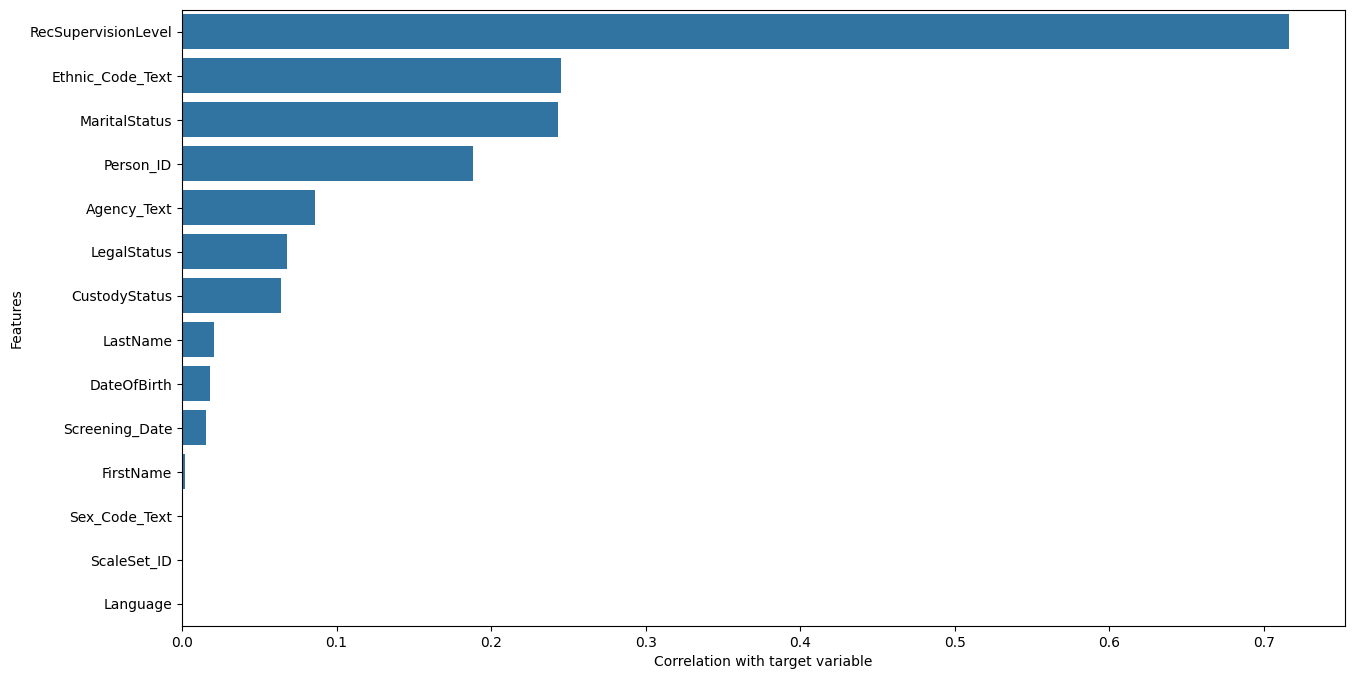

Column names of the 15 best features:
Index(['RecSupervisionLevel', 'Ethnic_Code_Text', 'MaritalStatus', 'Person_ID',
       'Agency_Text', 'LegalStatus', 'CustodyStatus', 'LastName',
       'DateOfBirth', 'Screening_Date', 'FirstName', 'Sex_Code_Text',
       'ScaleSet_ID', 'Language'],
      dtype='object')


In [ ]:
#separate the target variable
y = df2['ScoreText']
X = df2.drop(columns=['ScoreText'])

#calculate correlation
corr = abs(X.corrwith(y))

# sort correlation values in descending order
corr = corr.sort_values(ascending=False)

# number of top k correlation features
k = 15

# get the top k correlation features
top_k_features = corr.index[:k]
corr_features = top_k_features

plt.figure(figsize=(15,8))
# plot the correlation values in a bar plot
sns.barplot(x=corr.values, y=corr.index)
plt.xlabel('Correlation with target variable')
plt.ylabel('Features')
plt.show()

print("Column names of the {} best features:".format(k))
#print the column names of top k correlation features
print(top_k_features)

In [ ]:
columns_to_drop = ['FirstName', 'Sex_Code_Text','ScaleSet_ID', 'Language']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df.shape

(11372, 11)

In [ ]:
df.head()

,Person_ID,Agency_Text,LastName,Ethnic_Code_Text,DateOfBirth,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,ScoreText
0,51449,3,6986,1,4011,4,4,1,28,1,0
1,10419,2,5418,0,468,5,0,4,66,3,1
2,15292,3,6359,0,232,4,4,4,256,3,1
3,66783,2,1636,1,5349,5,2,4,121,2,1
4,65000,2,5949,0,5241,5,0,4,563,1,0


In [ ]:
path_recidivism_filtered = '/content/drive/MyDrive/datasets_mine/gnn_dataset/recidivism_filtered.csv'
df.to_csv(path_recidivism_filtered, index=False)

In [ ]:
dir_path = '/content/drive/MyDrive/datasets_mine/gnn_dataset/'

In [ ]:
# Perform 70/30 train-test split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['ScoreText'])

In [ ]:
train_df.shape, test_df.shape

((7960, 11), (3412, 11))

In [ ]:
train_df.to_csv(dir_path + 'recidivism_train.csv', index=False)
test_df.to_csv(dir_path + 'recidivism_test.csv', index=False)

# Train Test Traditional ML Models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [ ]:
# Separate features and target
X_train = train_df.drop(columns=['ScoreText'])
y_train = train_df['ScoreText']
X_test = test_df.drop(columns=['ScoreText'])
y_test = test_df['ScoreText']

# Standardize features (important for SVC)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Classifier': SVC(probability=True)
}

In [ ]:
# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Store the results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

In [ ]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Metrics:\n")
print(results_df)


Model Evaluation Metrics:

                           Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression        0.887163   0.969439  0.799531  0.876325  0.912529
Random Forest              0.883646   0.957372  0.803048  0.873446  0.904602
Decision Tree              0.811547   0.811730  0.811254  0.811492  0.811547
Support Vector Classifier  0.887456   0.970128  0.799531  0.876607  0.898749
